In [2]:
# Import sys and add FOOF location to path
import sys
sys.path.append('/Users/thomasdonoghue/Documents/GitCode/')

# Import FOOF
from foof import syn
from foof.fit import FOOF

# Import other packages
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.io as sio
%matplotlib inline

/Users/thomasdonoghue/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Load Data
matFile = 'Subject1_PSD_Vertex_0-500Hz.mat'
filename = os.path.join('/Users/thomasdonoghue/Documents/Research/1-Projects/OMEGA/2-Data/OMEGA/processed/sample_resting/', matFile)

# This pulls out the data in the matfile into a dictionary
dataMat = sp.io.loadmat(filename, appendmat=True, struct_as_record=False, squeeze_me=True)

# Pull out pieces from the dictionary
freqs = dataMat['Freqs']
psd = dataMat['TF']
labels = dataMat['RowNames']   # Scout names if scout data. Sensor/Vertex numbers if sensor/vertex

In [4]:
# Check data - get size
[nPSDs, nFreqs] = np.shape(psd)
freq_res = np.mean(np.diff(freqs))
print nPSDs
print freq_res
print labels

15002
0.29296875002
[    1     2     3 ..., 15000 15001 15002]


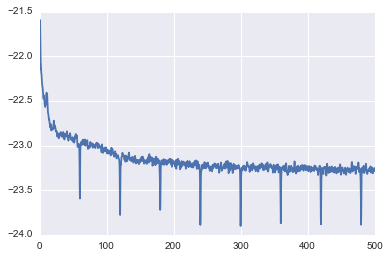

In [5]:
# Plot a psd (SemiLog)
plt.plot(freqs, np.log10(psd[0, :]))

In [6]:
# Extract PSD range of interest

# Drop Freqs below 3
f_low_mask = freqs > 3
freqs_ext = freqs[f_low_mask]
psd_ext = psd[:, f_low_mask]

# Drop freqs above 50
f_high_mask = freqs_ext < 50
freqs_ext = freqs_ext[f_high_mask]
psd_ext = psd_ext[:, f_high_mask]

In [7]:
# Select scout to extract
ind = 10000
print labels[ind]
# Reshape PSD to 2D column vector (for FOOF)
psd_example = np.reshape(psd_ext[ind, :], [len(freqs_ext), 1])

np.shape(psd_example)

10001


(160, 1)

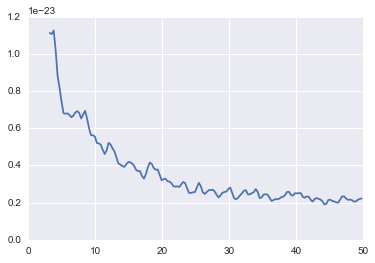

In [8]:
# Plot extracted PSD in low range
plt.plot(freqs_ext, psd_example)

In [9]:
# Test FOOF fit - 1 PSD
# Foof settings
min_p = 0.1
foof = FOOF(min_p = min_p, res = freq_res, fmin=freqs_ext.min(), fmax=freqs_ext.max())

In [10]:
# Fit model
foof.model(freqs_ext, psd_example)

In [11]:
# Print / Check parameters from the FOOF model
print foof.chi_
print foof.centers_
print foof.powers_
print foof.stdevs_

0.62047228092
[  7.25727106  11.07522181  18.5642275   33.7654901   40.31898782
  47.98525634]
[  6.91864414e-24   4.83589977e-24   4.07556890e-24   2.56516221e-24
   2.50944501e-24   2.16409377e-24]
[ 2.78704489  2.35164107  0.46491308  0.86129867  1.37637109  1.29402321]


In [ ]:
print("model: f {0}, f_sig {1}, chi {2}".format(
        np.round(foof.centers_, decimals=1),
        np.round(foof.stdevs_, decimals=1),
        np.round(foof.chi_, decimals=1))
     )

plt.subplot(211)
plt.plot(freqs_ext, psd_example[:,0]*10000000000000000000000, label='Data')
plt.plot(*syn.mfonef(mk=foof.powers_, 
                     mf=foof.centers_, 
                     mf_sig=foof.stdevs_, 
                     f0=3, 
                     fmax=50, 
                     chi=foof.chi_, 
                     res=freq_res), 
         label='Model'
        )
plt.xlabel("F (Hz)")
plt.ylabel("PSD")
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [7]:
# Foof settings
min_p = 0.1
foof = FOOF(min_p = min_p, res = freq_res, fmin=freqs_ext.min(), fmax=freqs_ext.max())

# Initialize matrices to store foof data
slopes_all = np.zeros([nPSDs, 1])
centers_all = np.zeros([nPSDs, 10])
powers_all = np.zeros([nPSDs, 10])
stdevs_all = np.zeros([nPSDs, 10])

In [ ]:
# Run FOOF on all PSDs
for i in range(0, nPSDs):
    
    # Pull out PSD and make right shape
    psd_temp = np.reshape(psd_ext[i, :], [len(freqs_ext), 1])
    
    # Fit FOOF
    foof.model(freqs_ext, psd_temp)
    
    # Collect Slope
    slopes_all[i, 0] = foof.chi_
    
    # Collect oscillatory params
    nOsc = len(foof.centers_)
    
    if(nOsc > 10):
        continue

    centers_all[i, 0:nOsc] = foof.centers_
    powers_all[i, 0:nOsc] = foof.powers_
    stdevs_all[i, 0:nOsc] = foof.stdevs_
    

In [39]:
def get_single_osc(osc_in):
    if(len(osc_in) == 0):
        return 0
    elif(len(osc_in) == 1):
        return osc_in
    else:
        return osc_in[0]

In [45]:
alphas_all = np.zeros([nPSDs, 1])
thetas_all = np.zeros([nPSDs, 1])
betas_all = np.zeros([nPSDs, 1])

# Oscillation Parameters
theta_low = 3
theta_high = 7
alpha_low = 7
alpha_high = 14
beta_low = 15
beta_high = 30

# Collect Alpha Oscillations
for i in range(0, nPSDs):

    centers_temp = centers_all[i, 0]

    thetas_temp = centers_temp[centers_temp > theta_low]; thetas_temp = thetas_temp[thetas_temp < theta_high]
    thetas_all[i, 0] = get_single_osc(thetas_temp)
    
    alphas_temp = centers_temp[centers_temp > alpha_low]; alphas_temp = alphas_temp[alphas_temp < alpha_high]
    alphas_all[i, 0] = get_single_osc(alphas_temp)
    
    betas_temp = centers_temp[centers_temp > beta_low]; betas_temp = betas_temp[betas_temp < beta_high]
    betas_all[i, 0] = get_single_osc(betas_temp)


In [52]:
savepath = 'Users/thomasdonoghue/Desktop/'
savename = 'Sample_Vertex'

save_dict = {}
save_dict['slopes']= slopes_all
save_dict['thetas']= thetas_all
save_dict['alphas']= alphas_all
save_dict['betas']= betas_all

sio.savemat(savename, save_dict)